In [87]:
import gdal
import pandas as pd
import numpy as np
import geopandas as gpd
import glob
import matplotlib.pyplot as plt

reg = 17 # region

In [4]:
def get_val(dat,gt=[],rb=[]):
    ''' Grab cell value based on data frame x and y variables.
    dat = dataframe containing x and y 
    gt = geotransform, of the index raster
    rb = raster band to pick data from
    '''
    mx = dat.x
    my = dat.y
    # transform to array coordinates
    px = int((mx-gt[0])/gt[1]) # x pixle
    py = int((my-gt[3])/gt[5]) # y pixle

    # extract the value
    intval = rb.ReadAsArray(px,py,1,1)
    return intval[0][0]

In [27]:
def get_watershed_areas(fl):
    '''
    Function to pull gageID and area from basin delineation shapefiles
    
    Inputs: 
        Shapefile Path
        
    Outputs:
        gageID
        watershed araea [sq km]
    
    '''
    gageID = fl.split('_')[-4]
    
    dat = gpd.read_file(fl) # read file
    area = dat.area_sqkm.sum()
    
    return gageID,area # return gageID and watershed area

In [28]:
shapefls = glob.glob('./data/gauges_proj/region_%s_*.shp'%(reg))

In [34]:
gageIDs = []
areas = []
for fl in shapefls:
    gageID,area = get_watershed_areas(fl)
    gageIDs.append(gageID)
    areas.append(area)

7.82 s ± 968 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [72]:
delineations = pd.DataFrame()
delineations['Gage_no'] = gageIDs
delineations['area_grass'] = areas
delineations['Gage_no'] = pd.to_numeric(delineations.Gage_no)

In [73]:
delineations.head()

,Gage_no,area_grass
0,10366000,0.0018
1,10370000,0.0063
2,10371000,0.0009
3,10371500,653.0229
4,10378500,431.9037


In [38]:
fl = './data/CPG_from_roy/region_17/MirAd_2012_100_CPG.tif'
ds = gdal.Open(fl)
gt = ds.GetGeoTransform()
rb = ds.GetRasterBand(1)

In [42]:
fl = './data/CATCHMENT_snapped_cpgDat_reg_17.csv'
testDat = pd.read_csv(fl)
#del testDat['Unnamed: 0']
#del testDat['Unnamed: 0.1']

In [43]:
testDat.head()

,cat,x,y,Gage_no,withdr1k,withdr1k_noData,mirad1k,mirad1k_noData,mirad250,mirad250_noData,...,nid_storage,nid_storage_noData,nid_normstorage,nid_normstorage_noData,npd_occur,npd_occur_noData,nlcd_2011_imperv,nlcd_2011_imperv_noData,ditches92_scale,ditches92_scale_noData
0,1,-1703250.0,2521380.0,13220500,1.125079,0.0,0.009270,0.014724,8.823986e-05,0.014293,...,0.000436,0.013824,0.000432,0.013824,0.0,0.013824,0.002137,0.015395,0.000000e+00,0.014378
1,2,-2192520.0,2442660.0,14362250,0.015169,0.0,0.000000,0.000080,0.000000e+00,0.000076,...,0.000000,0.000073,0.000000,0.000073,0.0,0.000073,0.000016,0.000080,0.000000e+00,0.000076
2,3,-2119230.0,2708040.0,14173500,0.210844,0.0,0.007658,0.001440,7.279971e-05,0.001679,...,0.000000,0.001684,0.000000,0.001684,0.0,0.001684,0.002853,0.001820,2.833502e-02,0.000640
3,4,-2093280.0,2594610.0,14145100,0.186470,0.0,0.000000,0.001934,0.000000e+00,0.001845,...,0.000563,0.001773,0.000555,0.001773,0.0,0.001773,0.000122,0.001981,0.000000e+00,0.001844
4,5,-2181330.0,2693610.0,14306400,0.064112,0.0,0.000048,0.000564,4.758926e-07,0.000541,...,0.000000,0.000521,0.000000,0.000521,0.0,0.000521,0.000190,0.000563,8.425584e-07,0.000540


In [44]:
testDat['MIRAD_PROSPER'] = testDat.apply(get_val,gt = gt, rb = rb, axis = 1)

In [45]:
testDat.MIRAD_PROSPER /= 100.

In [121]:
tmp = gpd.read_file('./data/CATCHMENT_gageloc_v1.shp')
tmp = tmp.loc[tmp.NHDPlusReg == '17']
gageloc = pd.DataFrame()
gageloc['area_nwis'] = tmp['Area_nwis']
gageloc['Gage_no'] = pd.to_numeric(tmp['Gage_no'])

,Gage_no,Gage_name,Gage_type,Lat_nwis,Long_nwis,Area_nwis,Lat_snap,Long_snap,COMID,COMID_meas,...,State,CHECKED,QC_notes1,REVIEWED,Rev_notes2,Ver_notes3,Gage_info,DropReason,QC_final,geometry
11694,13220500,"MALHEUR RIVER NEAR HOPE, OREG.",ContGage,43.944326,-117.481575,7847.663943,43.944136,-117.478147,24143220,5.816461,...,OR,SJ 11/28/16,OK. Snapped to flowline,AH/MCM 7/24/2017,ok,None,None,None,OK,POINT Z (-117.478147025617 43.94413621295035 0)
11695,14362250,"STAR GULCH NEAR RUCH, OR",ContGage,42.154014,-123.075323,41.439810,42.154458,-123.075346,23935979,95.879457,...,OR,"JAF, 12/21/2015",None,AH/MCM 7/24/2017,ok,None,None,None,OK,POINT Z (-123.0753461907914 42.15445778992844 0)
11696,14173500,"CALAPOOIA RIVER AT ALBANY, OR",ContGage,44.620677,-123.128984,963.475573,44.620621,-123.129067,23763521,81.455617,...,OR,None,None,AH/MCM 7/24/2017,ok,None,None,None,OK,POINT Z (-123.1290666825562 44.62062059464452 0)
11697,14145100,"HILLS CREEK LAKE NEAR OAKRIDGE, OR",ContGage,43.709575,-122.421111,1007.505371,43.707854,-122.420911,23751946,71.500827,...,OR,SJ 12/12/16,OK. Snapped to flowline,AH/MCM 7/24/2017,ok,None,None,None,OK,POINT Z (-122.4209111767744 43.70785357066743 0)
11698,14306400,"FIVE RIVERS NR FISHER, OREG.",CrestStage,44.337343,-123.827611,295.258643,44.337516,-123.827389,23886310,94.242643,...,OR,None,None,AH/MCM 7/24/2017,ok,None,None,None,OK,POINT Z (-123.8273893880673 44.33751639226584 0)


In [74]:
data = pd.merge(left=gageloc, right=testDat, on='Gage_no')
data = pd.merge(left=data, right=delineations, on='Gage_no')

In [75]:
data.head()

,area_nwis,Gage_no,cat,x,y,withdr1k,withdr1k_noData,mirad1k,mirad1k_noData,mirad250,...,nid_normstorage,nid_normstorage_noData,npd_occur,npd_occur_noData,nlcd_2011_imperv,nlcd_2011_imperv_noData,ditches92_scale,ditches92_scale_noData,MIRAD_PROSPER,area_grass
0,7847.663943,13220500,1,-1703250.0,2521380.0,1.125079,0.0,0.009270,0.014724,8.823986e-05,...,0.000432,0.013824,0.0,0.013824,0.002137,0.015395,0.000000e+00,0.014378,0.01,0.0018
1,41.439810,14362250,2,-2192520.0,2442660.0,0.015169,0.0,0.000000,0.000080,0.000000e+00,...,0.000000,0.000073,0.0,0.000073,0.000016,0.000080,0.000000e+00,0.000076,0.00,0.0108
2,963.475573,14173500,3,-2119230.0,2708040.0,0.210844,0.0,0.007658,0.001440,7.279971e-05,...,0.000000,0.001684,0.0,0.001684,0.002853,0.001820,2.833502e-02,0.000640,0.04,0.0009
3,1007.505371,14145100,4,-2093280.0,2594610.0,0.186470,0.0,0.000000,0.001934,0.000000e+00,...,0.000555,0.001773,0.0,0.001773,0.000122,0.001981,0.000000e+00,0.001844,0.00,0.0027
4,295.258643,14306400,5,-2181330.0,2693610.0,0.064112,0.0,0.000048,0.000564,4.758926e-07,...,0.000000,0.000521,0.0,0.000521,0.000190,0.000563,8.425584e-07,0.000540,0.00,0.0009


In [76]:
data['area_diff'] = data.area_nwis - data.area_grass

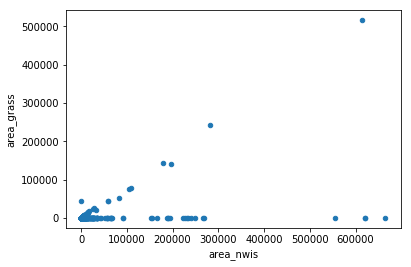

In [77]:
data.plot.scatter('area_nwis','area_grass')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f5ca22ac358>], dtype=object)

(0, 2000)

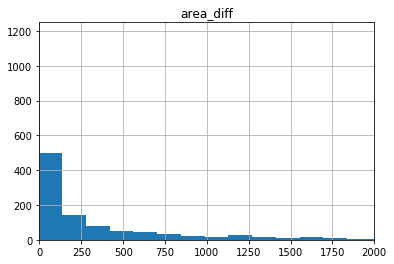

In [113]:
p = data.hist('area_diff', bins = 5000)
plt.ylim(0,1250)
plt.xlim(0,2000)

In [100]:
data.loc[data.area_diff.abs() < 50].shape

(403, 28)

In [123]:
tmp = data.sort_values('area_diff',ascending=True)[['area_nwis','area_grass','area_diff','Gage_no','x','y']]

In [126]:
tmp.shape

(1234, 6)

In [125]:
tmp.loc[tmp.Gage_no == 13022500]

,area_nwis,area_grass,area_diff,Gage_no,x,y
322,8974.308767,0.0009,8974.307867,13022500,-1199040.0,2338710.0


In [119]:
tmp.Gage_no.values[-1]

14246900

In [116]:
print('%s,%s'%(tmp.x.values[-1],tmp.y.values[-1]))

-2074380.0,2875920.0


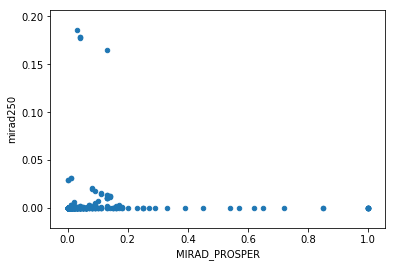

In [23]:
testDat.plot.scatter('MIRAD_PROSPER','mirad250')

In [36]:
testDat['resid'] = testDat.MIRAD_PROSPER - testDat.mirad250
testDat.loc[testDat.resid == 0].shape

(750, 26)

Text(0,0.5,'Count')

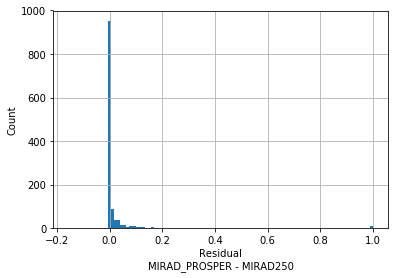

In [32]:
p = testDat.resid.hist(bins=100)
p.set_xlabel('Residual\nMIRAD_PROSPER - MIRAD250')
p.set_ylabel('Count')

In [37]:
testDat['resid'] = testDat.MIRAD_PROSPER - testDat.mirad1k
testDat.loc[testDat.resid == 0].shape

(707, 26)

Text(0,0.5,'Count')

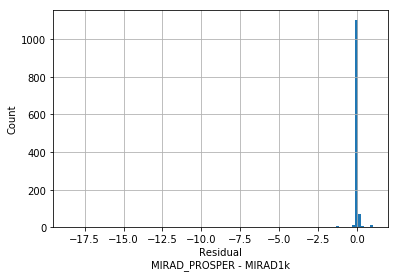

In [34]:
p = testDat.resid.hist(bins=100)
p.set_xlabel('Residual\nMIRAD_PROSPER - MIRAD1k')
p.set_ylabel('Count')